In [9]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

matplotlib.rcParams.update(matplotlib.rcParamsDefault)



In [10]:
df = pd.read_csv("../Fife-data/flex_networks.csv")
df["Timestamp"] = pd.to_datetime(df["Timestamp"], infer_datetime_format=True)
targetColumns = list(df.columns[1:4]) + list(df.columns[5:19]) + list(df.columns[21:22])
load = df[targetColumns].iloc[7247:8687].values
data = np.ravel(load)

realLoads = np.empty((18,30,48))
for day in range(realLoads.shape[1]):
    for hour in range(realLoads.shape[2]):
        for feeder in range(realLoads.shape[0]):
            realLoads[feeder][day][hour] = data[day*realLoads.shape[0]*realLoads.shape[2] + hour*realLoads.shape[0] + feeder]


In [11]:
load_data = np.loadtxt("forecastData.txt")
filter_data = load_data.reshape(load_data.shape[0], load_data.shape[1] // 48, 48)

In [12]:
load_data = np.loadtxt("scheduleData.txt")
schedule_data = load_data.reshape(load_data.shape[0], load_data.shape[1] // 48, 48)

newLoad = np.empty((18,30,48))
SOC = np.empty((18,30,48))
chargeRate = np.empty((18,30,48))
for feeder in range(SOC.shape[0]):
    for day in range(SOC.shape[1]):
        for hour in range(SOC.shape[2]):
            newLoad[feeder][day][hour] = schedule_data[feeder*newLoad.shape[1] + day][5][hour]
            SOC[feeder][day][hour] = schedule_data[feeder*SOC.shape[1] + day][0][hour]
            chargeRate[feeder][day][hour] = schedule_data[feeder*SOC.shape[1] + day][1][hour] - schedule_data[feeder*SOC.shape[1] + day][2][hour] 

d:\Programs\Python\lib\site-packages\ipykernel_launcher.py:44: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


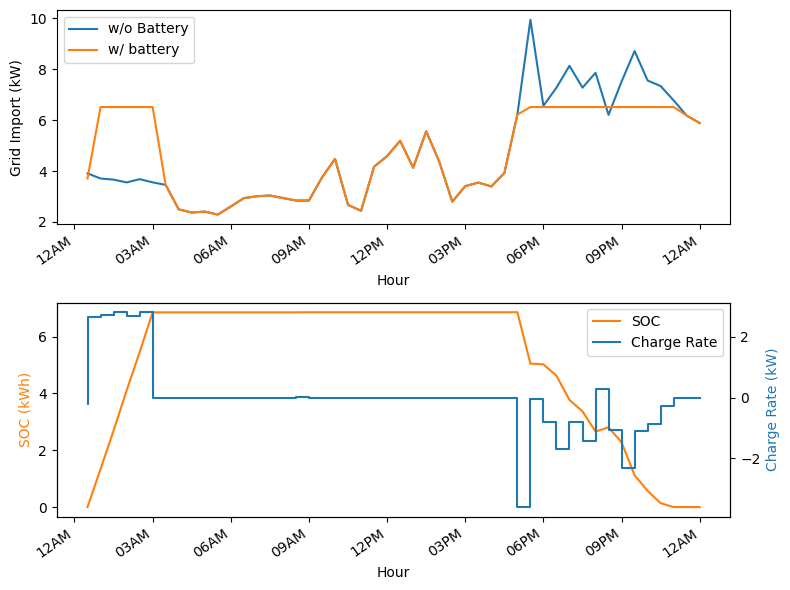

In [45]:
feeder = 0
day = 9

col1 = 'tab:blue'
col2 = 'tab:orange'


y = list(range(48))
fig, axs = plt.subplots(2)
axs[0].plot(df["Timestamp"].iloc[0:48],filter_data[feeder][day], label="w/o Battery")
axs[0].plot(df["Timestamp"].iloc[0:48],newLoad[feeder][day], label="w/ battery")
axs[0].legend()
axs[0].set_ylabel("Grid Import (kW)")
axs[0].set_xlabel("Hour")


axs[1].plot(df["Timestamp"].iloc[0:48],SOC[feeder][day],label="SOC", color=col2)
secax = axs[1].twinx()
secax.step(df["Timestamp"].iloc[0:48],chargeRate[feeder][day]*2, label="Charge Rate", color=col1)
secax.set_ylabel("Charge Rate (kW)", color=col1)
axs[1].set_ylabel("SOC (kWh)", color=col2)
axs[1].set_xlabel("Hour")

line1 = plt.Line2D([0], [0], label='SOC', color=col2)
line2 = plt.Line2D([0], [0], label='Charge Rate', color=col1)

handles = [line1, line2]
axs[1].legend(handles=handles)

for ax in axs:
  for label in ax.get_xticklabels(which='major'):
      label.set(rotation=35, horizontalalignment='right')

  myFmt = mdates.DateFormatter('%I%p')  #'%d %m %y %I %p'
  ax.xaxis.set_major_formatter(myFmt)



fig.set_figheight(6)
fig.set_figwidth(8)

plt.tight_layout()
plt.savefig("scheduleExampleOnForecast.svg", format='svg', dpi=1500, bbox_inches="tight")
fig.show()

In [14]:
peakLoad = np.loadtxt("peakLoads.txt")
#peakLoad = np.amax(load_data, axis=0)

class Battery:
    def __init__(self, maxLoad, chargeEfficiency=0.95, dischargeEfficiency=0.95):
        self.maxSOC = maxLoad * 0.25                    # in kWh
        self.maxChargeRate = (maxLoad * 0.25) / 2       # in kW
        self.maxDischargeRate = maxLoad * 0.25          # in kW
        self.chargeEfficiency = chargeEfficiency
        self.dischargeEfficiency = dischargeEfficiency


batteries = []
for i in range(filter_data.shape[0]):
    batteries.append(Battery(peakLoad[i]))

In [15]:
newSOC = np.empty((18,30,48))
newChargeRate = np.empty((18,30,48))
gridImport = np.empty((18,30,48))

for feeder in range(newSOC.shape[0]):
    for day in range(newSOC.shape[1]):
        for hour in range(newSOC.shape[2]):
            if hour == 0:
                newChargeRate[feeder][day][hour] = 0
                newSOC[feeder][day][hour] = 0
            else:
                newSOC[feeder][day][hour] = newSOC[feeder][day][hour-1] + chargeRate[feeder][day][hour]
                if newSOC[feeder][day][hour] > batteries[feeder].maxSOC:
                    # Assume extra charge is simply wasted
                    newChargeRate[feeder][day][hour] = chargeRate[feeder][day][hour]
                    newSOC[feeder][day][hour] = batteries[feeder].maxSOC
                elif newSOC[feeder][day][hour] < 0:
                    # Charge less than zero must be accounted for
                    newChargeRate[feeder][day][hour] = chargeRate[feeder][day][hour] - newSOC[feeder][day][hour]
                    newSOC[feeder][day][hour] = 0
                else:
                    newChargeRate[feeder][day][hour] = chargeRate[feeder][day][hour]
            
            gridImport[feeder][day][hour] = realLoads[feeder][day][hour] + 2*newChargeRate[feeder][day][hour]


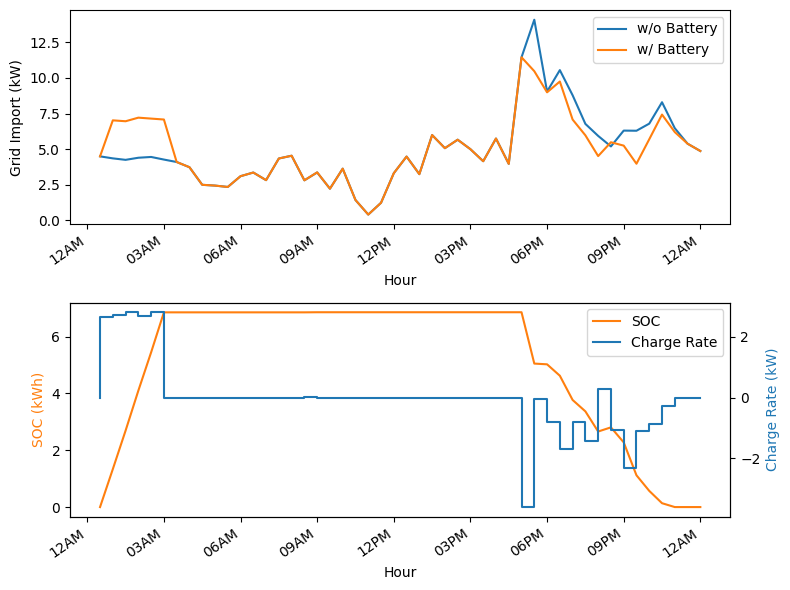

In [46]:
feeder = 0
day = 9

col1 = 'tab:blue'
col2 = 'tab:orange'

fig, axs = plt.subplots(2)
axs[0].plot(df["Timestamp"].iloc[0:48],realLoads[feeder][day], label="w/o Battery")
axs[0].plot(df["Timestamp"].iloc[0:48],gridImport[feeder][day], label="w/ Battery")
axs[0].set_ylabel("Grid Import (kW)")
axs[0].set_xlabel("Hour")
axs[0].legend()

axs[1].plot(df["Timestamp"].iloc[0:48],newSOC[feeder][day],label="SOC", color=col2)
secax = axs[1].twinx()
secax.step(df["Timestamp"].iloc[0:48],newChargeRate[feeder][day]*2, label="Charge Rate", color=col1)
secax.set_ylabel("Charge Rate (kW)", color=col1)
axs[1].set_ylabel("SOC (kWh)", color=col2)
axs[1].set_xlabel("Hour")

line1 = plt.Line2D([0], [0], label='SOC', color=col2)
line2 = plt.Line2D([0], [0], label='Charge Rate', color=col1)

handles = [line1, line2]
axs[1].legend(handles=handles)

for ax in axs:
  for label in ax.get_xticklabels(which='major'):
      label.set(rotation=35, horizontalalignment='right')

  myFmt = mdates.DateFormatter('%I%p')  #'%d %m %y %I %p'
  ax.xaxis.set_major_formatter(myFmt)

fig.set_figheight(6)
fig.set_figwidth(8)

plt.tight_layout()
plt.savefig("scheduleExample.svg", format='svg', dpi=1500, bbox_inches="tight")
plt.show()

In [35]:
print(max(filter_data[feeder][day]))
print(max(newLoad[feeder][day]))
print(max(realLoads[feeder][day]))
print(max(gridImport[feeder][day]))
batteries[0].maxDischargeRate

9.947784845801294
6.516106679117885
14.0842
11.448533333333302


6.85455

In [17]:
peakChangeRatio = []

for feeder in range(gridImport.shape[0]):
    realLoadsMax = []
    batteryLoadsMax = []
    for day in range(gridImport.shape[1]):
        realLoadsMax.append(max(realLoads[feeder][day]))
        batteryLoadsMax.append(max(gridImport[feeder][day]))
    peakChangeRatio.append(np.mean(np.divide(batteryLoadsMax, realLoadsMax)))

peakChangeRatio = np.asarray(peakChangeRatio)

# Value > 1 means peak is decreasing, < 1 means peak is increasing
percentageReduction = (1-peakChangeRatio) * 100
np.mean(percentageReduction)

7.073960660597546

In [18]:
for i in range(18):
    i
    #print(percentageReduction[i])

In [19]:
dayReduction = []
for feeder in range(gridImport.shape[0]):
    for day in range(gridImport.shape[1]):
        dayReduction.append((np.divide(max(gridImport[feeder][day]),max(realLoads[feeder][day]))))

dayPercentageReduction = (1-np.asarray(dayReduction))*100
np.mean(dayPercentageReduction)

7.0739606605975425

In [20]:
for i in range(540):
    print(dayPercentageReduction[i])

16.716260287970975
0.0
23.653113821859183
8.360548862235017
9.195636760385584
4.10564276258164
6.242315894973183
3.470834732479444
13.104490204583874
18.71364129071369
13.14102814241911
20.386433187250507
0.0
0.0
12.304888829005078
11.748486250094315
20.718654196686813
0.0
-1.0346013122317421
4.760824637312178
1.1408223025551223
16.557441236161818
6.818334643014912
21.74652245337535
-4.129840754962366
15.55342386711106
-0.76009396771064
10.941962435309637
-3.1844812382579857
4.1593849952377475
13.331463015487454
3.1390958528932367
0.0
7.301992627131748
8.72520151851771
10.498884219901816
14.756915511814285
16.280616203036846
7.161180916059717
6.697311194411526
0.0
19.29251126980478
15.805495722157447
-4.493969441934476
4.857113849847739
9.199692846433404
10.38096415667229
-9.782335819237264
7.325424536032066
9.047563722208029
-6.843143127235973
13.50627276327796
0.0
7.991228233431702
-3.2472000697028047
-3.633197919259712
1.9712551613425222
14.345089391027654
8.100457653547888
-4.71793

In [21]:
np.argmax(peakChangeRatio)
print(max(peakChangeRatio))

print(max(realLoads[3][25]) / max(gridImport[3][25]))

0.9812926458168676
1.5167138730755176
